<a href="https://colab.research.google.com/github/nouranali/SureStart_VAILTraining/blob/master/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/tmp/autoencoder"
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
from keras.datasets import mnist
import numpy as np
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np

In [6]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [7]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [8]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [9]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 219.7345 - val_loss: 166.2241
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 165.1658 - val_loss: 163.4909
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 162.9897 - val_loss: 161.5867
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 160.8602 - val_loss: 159.7713
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 159.0565 - val_loss: 158.5268
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 157.6295 - val_loss: 157.4623
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 156.6172 - val_loss: 156.3029
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.6099 - val_loss: 155.3976
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 15

In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=32)

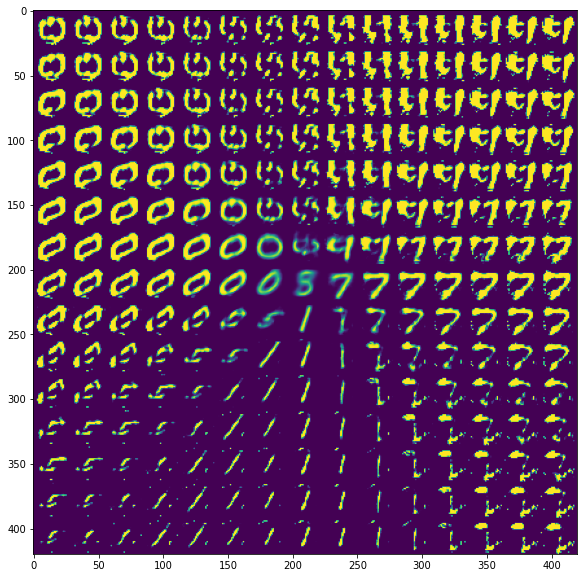

In [18]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()